# Don't use Forsyth-Edwards Notation to play chess with LLMs

Anton Antonov    
Raku Advent Calendar 2024   
November 2024   

-----

## Introduction

This notebook (computational document) shows several topics:

- Making nice plots of chess positions (using Raku's "JavaScript::D3")
- Staging and interactively using an LLM persona for playing chess
- Deficiencies of LLMs playing chess via [Forsyth-Edwards Notion](https://en.wikipedia.org/wiki/Forsyth–Edwards_Notation).

**Remark:** Playing chess (really) well with LLMs is not the focus of this notebook (document.)

### On chess playing

There are plenty of (research) articles, posts, software packages, or coding projects about *LLMs-and-chess*.

At least half a dozen of those articles and posts proclaim much better results than the examples given below.

Those articles or posts, though, use:

- Well known chess games
- Other than FEN notations 
    - Portable Game Notation (PGN)
    - Arithmetic Notation (AN)
    - Textual/ASCII chess position representation
- Connections to 3rd party programs

------

## LLM persona -- ***ChessMaster***

Here is the prompt of an LLM persona for playing chess:

In [24]:
#% chat cm prompt, model=gpt-4o, max-tokens=4096, temperature=0.25
You are a ChessMaster engaged in a text-based chess game. You play the opponent, usually with the black chess pieces and pawns. 
The game should be easy to follow and adhere to standard chess rules. 

Here is how you behave:

- Forsyth-Edwards Notation (FEN) strings to communicate the state of the gameplay.

- Ensure you play by standard chess rules.

- Ensure the game interprets and executes these moves correctly.

- Allow the player to input using 
    1. Algebraic Notation (AN) input, for example, "e2 to e4" to move a pawn
    2. Descriptive input, like, "bishop from a3 to f8" 

- When the user gives you AN string you respond with three strings: 
    1. FEN position after user's AN input is played
    2. Your move given as AN string
    3. FEN position after your AN move is played

- If asked provide clear feedback to the player after each move, including the move itself.
    - For example, "You moved: e2 to e4" and "Opponent moved: e7 to e5".

- If you take a figure of the user make sure say that in your responses. 

- If asked provide player guidance
    - Include in-game guidance resources or instructions that explain chess rules, move input, and special conditions like check and checkmate.
    
- Proclaim when the user gives you AN move that is wrong, non-complient with the stanard chess rules.

- When the user asks you to start a game without specifying a FEN string:
    - You give the standard initial position as start.
    
- You play the black opponent, the user plays the white, except if the user says that he plays the black side.

Chat object created with ID : cm.

A few observations on the prompt above:

- The prompt is carefully crafted.
    - Other research efforts often use much shorter prompts like "You chess master."
- FEN is explicitly postulated as the way to communicate the "game field."
- Both AN and plain English are "allowed" as user input.

**Remark:** Below the LLM persona is referred to as "ChessMaster" or "CM".

--------

## Chess position plotting setup

This section shows the setup for plotting chess positions *while using a [Raku Chatbook](https://raku.land/zef:antononcube/Jupyter::Chatbook)*.

Packages:

In [2]:
use Data::Importers;
use FEN::Grammar;
use JavaScript::D3;
use JavaScript::D3::Chess; # Needed only to show tuning parameters 


Priming for JavaScript plots code rendering:

In [3]:
%% javascript
require.config({
     paths: {
     d3: 'https://d3js.org/d3.v7.min'
}});

require(['d3'], function(d3) {
     console.log(d3);
});

Styling options, (default and "greens"):

In [4]:
# Default style
my %opts =
    color-palette => 'YlOrBr',
    black-square-value => 0.75,
    white-square-value => 0.25,
    whites-stroke-color => 'darkslategrey',
    tick-labels-color => 'grey',
    background => '#1F1F1F',
    title-color => 'Silver',
    width => 400;

# chess.com style
my %opts-greens =
    color-palette => 'Greens',
    black-square-value => 0.8,
    white-square-value => 0.2,
    whites-fill-color => 'White',
    whites-stroke-color => 'DarkSlateGray',
    blacks-fill-color => '#1F1F1F',
    blacks-stroke-color => 'Black',
    tick-labels-color => 'Grey',
    background => '#1F1F1F',
    title-color => 'Silver',
    width => 400;

(%opts.elems, %opts-greens.elems)

(8 11)

Example of initial chess position plot (without using a FEN string):

In [5]:
#%js
js-d3-chessboard(|%opts, title => 'Initial position') ~
js-d3-chessboard('8/8/8/8/8/8/8/8',|%opts-greens, title => 'Empty chessboard')

Using a different plotting style with non-trivial FEN strings:

In [6]:
#%js
[
    "rnbqkB1r/pppp1ppp/5n2/4p3/8/1P6/P1PPPPPP/RN1QKBNR b KQkq - 0 3",
    "4kb1r/p4ppp/4q3/8/8/1B6/PPP2PPP/2KR4"
] ==>
js-d3-chessboard(
    tick-labels-color => 'silver', 
    black-square-value => 0.5, 
    background => '#282828',
    margins => 15,
    width => 350
)

In "JavaScript:D3":

- Input chess position strings are processed with "FEN::Grammar"
- Almost any element of chess position plotting is tunable
- Chess position plotting is based on heatmap plotting
    - Hence, arguments of `js-d3-heatmap-plot` can be used.

Here are the explicit tunable parameters:

In [7]:
.say for &JavaScript::D3::Chess::Chessboard.candidates.map({ $_.signature.params».name }).flat.unique.grep({ $_.Str ∉ <@data $data %args $div-id>}).sort

$background
$black-square-value
$blacks-fill-color
$blacks-stroke-color
$color-palette
$format
$height
$margins
$opacity
$tick-labels-color
$title
$white-square-value
$whites-fill-color
$whites-stroke-color
$width


-----

## Chess notation sub-strings extraction

In this section are given several methods for extracting FEN strings from (free) text strings. (I.e. chess LLM outputs.)

A function to check whether is a FEN string or not:

In [8]:
my sub is-fen-string(Str:D $txt) {
    my $match = FEN::Grammar.parse($txt);
    return $match.defined;
}

&is-fen-string

Here is a way to use that predicate function:

In [9]:
my sub fen-specs-by-predicate(Str:D $txt) {
   
  # First the faster check 
  my @res = do with $txt.match(/ $<delim>=('`'|\v) $<fen>=(<-[\v`]>+) $<delim> /, :g) {
     $/.values.map({ $_<fen>.Str.trim => &is-fen-string($_<fen>.Str.trim)});
  }
  @res .= grep({ $_.value });

  return @res».key if @res; 

  # Slow(er) check
  my @res2 = do with $txt.match(/ $<fen>=(.*) <?{ is-fen-string($<fen>.Str) }> /, :g) {
     $/.values.map({ $_<fen>.Str.trim });
  } else { Nil }

  return @res2; 
}

&fen-specs-by-predicate

**Remark:** The functions `is-fen-string` and `fen-specs-by-predicate` are useful if 3rd party chess notation packages are used. (Not necessarily Raku-grammar based.)

Here is a fast and simple to use a Raku grammar to extract FEN strings:

In [10]:
my sub fen-specs(Str:D $txt) {
    return do with $txt.match( /<FEN::Grammar::TOP>/, :g) { $/».Str };
}

&fen-specs

Here are examples using both approaches:

In [11]:
my $txt = q:to/END/;
You moved: b2 to b3

FEN after your move: `rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR b KQkq - 0 1`

Now, it's my turn. I'll play:

Opponent moved: e7 to e5

FEN after my move: `rnbqkbnr/pppp1ppp/8/4p3/8/1P6/P1PPPPPP/RNBQKBNR w KQkq e6 0 2`

Your move!
END

say "fen-specs-by-predicate : ", fen-specs-by-predicate($txt).raku;
say "fen-specs              : ", fen-specs($txt).raku;

fen-specs-by-predicate : ["rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR b KQkq - 0 1", "rnbqkbnr/pppp1ppp/8/4p3/8/1P6/P1PPPPPP/RNBQKBNR w KQkq e6 0 2"]
fen-specs              : ("rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR b KQkq - 0 1", "rnbqkbnr/pppp1ppp/8/4p3/8/1P6/P1PPPPPP/RNBQKBNR w KQkq e6 0 2")


-----

## Play 1

This section has an example play (again within a [Raku chatbook](https://raku.land/zef:antononcube/Jupyter::Chatbook).)

Starting a game:

In [25]:
#% chat cm > markdown
Let us start a new game.

Great! Let's start a new game. Here's the standard initial position in Forsyth-Edwards Notation (FEN):

`rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1`

It's your move! You can use algebraic notation (e.g., "e2 to e4") or descriptive input (e.g., "pawn from e2 to e4").

Plotting the FEN strings from the LLM output:

In [26]:
#%js
js-d3-chessboard(fen-specs(cbpaste), |%opts)

User first move:

In [27]:
#% chat cm > markdown
b2 to b3

You moved: b2 to b3

Here's the updated FEN position after your move:

`rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR b KQkq - 0 1`

Now it's my turn. I'll play:

e7 to e5

Here's the updated FEN position after my move:

`rnbqkbnr/pppp1ppp/8/4p3/8/1P6/P1PPPPPP/RNBQKBNR w KQkq e6 0 2`

Your move!

Plotting the FEN strings from the LLM output:

In [28]:
#%js
js-d3-chessboard(fen-specs(cbpaste), |%opts)

Another user move:

In [29]:
#% chat cm > markdown
Bishop from c1 to a3

You moved: Bishop from c1 to a3

Here's the updated FEN position after your move:

`rnbqkbnr/pppp1ppp/8/4p3/8/BP6/P1PPPPPP/RN1QKBNR b KQkq - 1 2`

Now it's my turn. I'll play:

d7 to d6

Here's the updated FEN position after my move:

`rnbqkbnr/ppp2ppp/3p4/4p3/8/BP6/P1PPPPPP/RN1QKBNR w KQkq - 0 3`

Your move!

User move and ChessMaster move:

In [30]:
#%js
js-d3-chessboard(fen-specs(cbpaste), |%opts)

Another user move -- taking the pawn at `d6`:

In [31]:
#% chat cm > markdown
bishop from a3 to d6

You moved: Bishop from a3 to d6

Here's the updated FEN position after your move:

`rnbqkbnr/ppp2ppp/3B4/4p3/8/1P6/P1PPPPPP/RN1QKBNR b KQkq - 0 3`

You captured my pawn on d6.

Now it's my turn. I'll play:

c7 to d6

Here's the updated FEN position after my move:

`rnbqkbnr/ppp2ppp/3p4/4p3/8/1P6/P1PPPPPP/RN1QKBNR w KQkq - 0 4`

Your move!

The chess positions clearly see the wrong LLM moves (or FEN strings):

In [32]:
#%js
js-d3-chessboard(fen-specs(cbpaste), |%opts)

Trying to fix it:

In [33]:
#% chat cm > markdown
Well, you removed the bishop which took the pawn on `d6` and you kept on `d6` that pawn of yours.

Yes, that's correct. When you moved your bishop from a3 to d6, it captured my pawn on d6. On my turn, I recaptured your bishop with my pawn from c7 to d6. 

Here's the current FEN position after my move:

`rnbqkbnr/ppp2ppp/3p4/4p3/8/1P6/P1PPPPPP/RN1QKBNR w KQkq - 0 4`

Your move!

The FEN string of the "correction" is the same as above: 

In [ ]:
#%js
js-d3-chessboard(fen-specs(cbpaste), |%opts)

----

## Chess position recognition

It is interesting to review the abilities of the vision (or "omni") LLM models to recognize chess positions and produce the (correct) corresponding notation strings.

**Remark:** (Some of) the LLM-vision models explicitly state that they are not good at recognizing chess positions.
(For example, see [OpenAI's "Vision/Limitations"](https://platform.openai.com/docs/guides/vision#limitations).)

Consider the following image from [this StackExchange post](https://puzzling.stackexchange.com/q/125524):

In [ ]:
#%js
my $url = 'https://i.sstatic.net/uKnenm.png';
js-d3-image-display($url)

Here image's corresponding Base64 string is obtained and rendered:

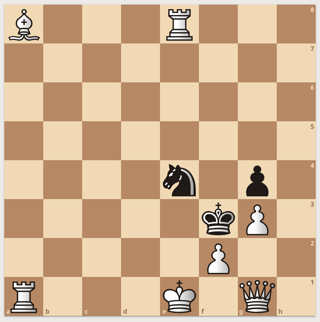

In [14]:
#%markdown
my $imgBase64 = data-import($url, format => 'md-image');

**Remark:** The Raku chatbook visualizations via JavaScript and URLs are faster.

Here is an LLM vision application (using image's URL):

In [15]:
#% markdown
my $chessDescr = llm-vision-synthesize('Describe the following image:', $url);

The image shows a chess position on a standard 8x8 board. The pieces are arranged as follows:

- White pieces:
  - Bishop on a8
  - Rook on e8
  - Rook on a1
  - Queen on g1
  - King on e1
  - Pawn on f2
  - Pawn on g3

- Black pieces:
  - Knight on e4
  - King on f3
  - Pawn on g4

It's White's turn to move.

**Remark:** The positions of both the white and black figures are recognized correctly.

Get Raku code instead of a textual description:

In [16]:
my $chessSpec = llm-synthesize([
    'Convert the following chess position description into a JSON array of dictionaries.',
    'Conversion examples:',
    '- "Black rook on e8" converts to `{x: "e", y: "8", z: "R"}`',
    '- "White bishop on a4" converts to `{x: "a", y: "4", z: "b"}`',
    'The key "z" has small letters for the blacks, and capital letters for the whites.',
    'DESCRIPTION:',
    $chessDescr,
    llm-prompt('NothingElse')('JSON')
    ], 
    e => llm-configuration('chatgpt', model => 'gpt-4o', temperature => 0.4),
    form => sub-parser('JSON'):drop
);

[{x => a, y => 8, z => B} {x => e, y => 8, z => R} {x => a, y => 1, z => R} {x => g, y => 1, z => Q} {x => e, y => 1, z => K} {x => f, y => 2, z => P} {x => g, y => 3, z => P} {x => e, y => 4, z => n} {x => f, y => 3, z => k} {x => g, y => 4, z => p}]

In [17]:
#%html 
$chessSpec ==> to-html(field-names => <x y z>)

x,y,z
a,8,B
e,8,R
a,1,R
g,1,Q
e,1,K
f,2,P
g,3,P
e,4,n
f,3,k
g,4,p


Here we compare the original image with its LLM derived description (converted to a Raku array of maps):

In [ ]:
#%js
js-d3-image-display($url)
~ "\n\n" ~
js-d3-chessboard($chessSpec, |%opts, title => 'Text description to JSON')

Comparing the images it can be seen that a correct LLM-vision recognition JSON spec was obtained.

-----

## Using FEN strings is counter-productive

In this subsection is demonstrated that LLMs have hard time converting correctly from- or to FEN strings.

Defining LLM-functions and LLM-configurations used below (more than once):

In [22]:
# Configurations
my $conf4o = llm-configuration('chatgpt', model => 'gpt-4o', temperature => 0.4);
my $confGemini = llm-configuration('gemini', model => 'gemini-1.5-pro-latest', temperature => 0.2);

# Vision function
my sub fen-vision(Str:D $src, *%args) { 
    llm-vision-synthesize([
        'Describe the following chess position using Forsyth-Edwards notation.',
        llm-prompt('NothingElse')('FEN')
    ], 
    $src, 
    |%args)
}

# Conversion function
my sub fen-from-descr(Str:D $src, *%args) { 
    llm-synthesize([
        'Convert the following chess position description into a FEN spec.', 
        $src,
        llm-prompt('NothingElse')('FEN')
    ],
    |%args).subst(/^ '```' \w* | '```' $/, :g).trim
}

&fen-from-descr

Get FEN string corresponding to the LLM-obtained image description:

In [23]:
my $fenTxt = &fen-from-descr($chessDescr, e => $conf4o);
my $fenTxtByGemini = &fen-from-descr($chessDescr, e => $confGemini);

($fenTxt, $fenTxtByGemini)

(r3R3/B7/8/8/4n1p1/6k1/5P1P/R3Q2R w - - 0 1 B1R3K1/8/8/4n3/4k1p1/6P1/5P2/R3K1Q1 w - - 0 1)

Instead of a "plain English" description, request a FEN string to be returned for the given image:

In [24]:
my $fenImg = fen-vision($url, e => $conf4o)

8/B3R3/8/8/4n1p1/5kP1/5P2/R3K1Q1 b - - 0 1

Using one of latest Gemini's vision/omni models (with Gemini's vision models image Base64 strings have to used instead of image URLs):

In [25]:
my $fenImgByGemini = fen-vision($imgBase64, e => $confGemini)

8/8/8/8/4n3/8/4kpp1/R1K2Q1R w - - 0 1


Here is a comparison of the original image (_bottom right_) and the chess position plot based on LLM recognitions above:

In [35]:
#% js
  my %opts2 = %opts.clone; %opts2<width> = 350; %opts2<title-font-size> = 12;

  [
      'Text description to FEN (OpenAI, wrong)' => $fenTxt,
      'Text description to FEN (Gemini, wrong)' => $fenTxtByGemini,
      'Text description to JSON (OpenAI, correct)' => $chessSpec,
      'Image to FEN (OpenAI, wrong)' => $fenImg,
      'Image to FEN (Gemini, wrong)' => $fenImgByGemini
  ].map({
    js-d3-chessboard($_.value, |%opts2, title => $_.key)
  }).join("\n")
  ~ "\n" ~
  js-d3-image-display($url) 

Here are a few observations:

- The FEN-titled images shows several mistakes of chess figures mis-placements and/or omissions. 
    - E.g. white have no king.

- The tried LLMs do not faithfully convert FEN specs:

    - Plain text chess position descriptions.

    - Chess position images 

We can conjecture that due to FEN's aggregational nature LLMs have hard time deriving correct FEN representations.

-----

## Possible explanation

In this section we ask one of ChatGPT's reasoning models -- ["o1-preview"](https://platform.openai.com/docs/models#o1) -- to prove or disprove the conjecture.

In [ ]:
#% openai > markdown, model=o1-preview, max-tokens=4096, temperature=0.4
Reason, prove, dis-prove, or explain the following conjecture:
> The chess Forsyth-Endwards Notation (FEN) has "aggregational nature", that is why LLMs have hard time 
> deriving correct FEN representations from textual descriptions or from images.

----

## Leftover comments

A few leftover comments:

- The chess plotting functionalities of ["JavaScript::D3" were developed 11 months ago](https://github.com/antononcube/Raku-JavaScript-D3/commits/main/lib/JavaScript/D3/Chess.rakumod).
- Some of my friends and coworkers have mentioned more than a few times that I am suspiciously weak and playing chess.
    - Yeah, sure, but I can program the [Alpha-Beta algorithm](https://en.wikipedia.org/wiki/Alpha–beta_pruning).
        - And have done so a few times.
        - Coming to Raku soon...
- Facilitating and experimenting with different styles for plotting of the chess positions is/was both interesting and time consuming.
    - Almost any element of the chess position plotting is tunable.

-----

## References

### Articles, blog posts

[DM1] dynomight,
["Something weird is happening with LLMs and chess](https://dynomight.net/chess/),
(2024),
[dynomight.net](https://dynomight.net/).

### Packages, repositories

[AAp1] Anton Antonov,
[JavaScript::D3 Raku package](https://github.com/antononcube/Raku-JavaScript-D3),
(2022-2024),
[GitHub/antononcube](https://github.com/antononcube).

[AAp2] Anton Antonov,
[Jupyter::Chatbook Raku package](https://github.com/antononcube/Raku-Jupyter-Chatbook),
(2023-2024),
[GitHub/antononcube](https://github.com/antononcube).

[AAp3] Anton Antonov,
[Data::Importers Raku package](https://github.com/antononcube/Raku-Data-Importers),
(2022-2024),
[GitHub/antononcube](https://github.com/antononcube).

[AAp4] Anton Antonov,
[LLM::Functions Raku package](https://github.com/antononcube/Raku-LLM-Functions),
(2023-2024),
[GitHub/antononcube](https://github.com/antononcube).

[AAp5] Anton Antonov,
[LLM::Prompts Raku package](https://github.com/antononcube/Raku-LLM-Prompts),
(2023-2024),
[GitHub/antononcube](https://github.com/antononcube).

### Videos